# STEAM RECOMMENDER SYSTEM

### Importing necessary packages

In [ ]:
!pip install

In [245]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from collections import Counter

from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_splitfrom collections 
import Counter
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
nltk.download('punkt')
import re
import string

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Visitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing the cleaned data set

In [246]:
# importing the data set
steam = pd.read_csv('steam_rs.csv')

In [247]:
# displaying 5 rows of the data frame
steam.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
2,187131847,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
4,176410694,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113


In [248]:
# getting name count
steam_name_count = pd.DataFrame(steam.groupby('name').size().sort_values(), columns=['count'])
steam_name_count

,count
name,
Putt-Putt and Pep's Dog on a Stick,1
Battle Mages,1
Gold Rush! Anniversary,1
Vertex Dispenser,1
Verde Station,1
...,...
Counter-Strike,1424
Left 4 Dead 2,1752
Unturned,2632


In [249]:
# checking games based on their rank
steam.groupby(['name'])['rank'].mean().reset_index()

,name,rank
0,0RBITALIS,71.785714
1,10 Second Ninja,85.897436
2,"10,000,000",89.694459
3,100% Orange Juice,93.090154
4,1000 Amps,78.877888
...,...,...
2292,rFactor 2,86.908517
2293,resident evil 4 / biohazard 4,86.958567
2294,rymdkapsel,82.568807
2295,samurai_jazz,68.181818


In [250]:
ratings = steam['rank'].value_counts()
ratings

84.951130    9682
94.121113    4646
90.935142    2632
97.067529    1752
97.461406    1424
             ... 
22.826087       1
85.915493       1
55.185185       1
66.812227       1
82.377049       1
Name: rank, Length: 2182, dtype: int64

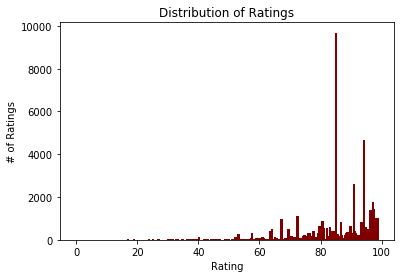

In [251]:
# plotting distribution of ratings
ratings_sorted = sorted(list(zip(ratings.index, ratings)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='maroon')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [252]:
# checking users with the highest amount of hours spent playing 
steam.groupby('id')['hours_of_play'].agg(np.sum).sort_values(ascending=False)[0:10]

id
73017395     11754.0
100630947    10445.7
153382649     9640.0
130882834     7765.0
52567955      7704.8
14544587      7242.7
121199670     6755.2
67694595      6269.7
86256882      6242.7
12660489      6061.5
Name: hours_of_play, dtype: float64

In [253]:
print("Unique SteamIds :", steam["id"].nunique())
print("Unique AppIds :", steam["name"].nunique())

Unique SteamIds : 10350
Unique AppIds : 2297


Text(0.5, 1.0, 'Hours of play per game')

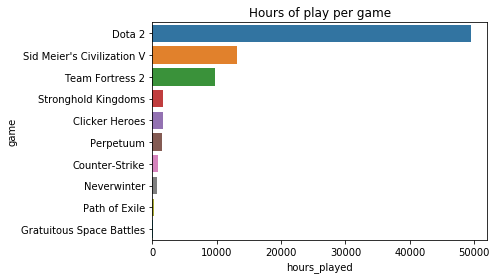

In [254]:
# graphing the amount of hours spent on a game
top = 10

user_counts = steam.groupby('id')['hours_of_play'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = steam['id'].isin(user_counts.index)
df_infos_user = steam.loc[mask].loc[steam['purchase'] == 'play']
hours_played = df_infos_user.groupby('name')['hours_of_play'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:10]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)

plt.title("Hours of play per game")

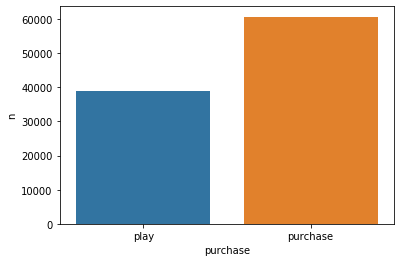

In [255]:
# checking amount of users that have either played or purchased a game
actions = steam.groupby('purchase')['purchase'].agg('count')
actions = pd.DataFrame({'purchase': actions.index, 'n': actions.values})
sns.barplot(x = 'purchase', y = 'n', data = actions)

# Content based model

Content based recommender systems predict what the user likes based on what they have liked in the past. This creates personlizes recommendations for the user based on interests, and other such factors. To recommend a user similar items that the user has previously liked, TFIDF can be used, as it helps identify which item is similar to each other. Each of these items are represented using TFIDF vectors.
<br><br>
TFIDF is a very crucial in building the recommender system. Term frequency (TF) is the frequencies of a specific word in a document, and inverse document frequency (IDF) is the universe of document frequencies throughout the entire corpus of documents.

In [256]:
# displaying the data frame
steam.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
2,187131847,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
4,176410694,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113


In [257]:
# checking the current shape of the data frame
steam.shape

(99632, 25)

In [258]:
# dropping the duplicate ids, and keeping the most recent ones as making sure it dosent remove all the unique games in the data frame
steam.drop_duplicates(subset = ['id', 'name'],
                     keep = 'last', inplace = True)

In [259]:
# checking the shape after removing duplicates
steam.shape

(60446, 25)

In [260]:
# checking the amount of unique ids and appids
print("Unique SteamIds :", steam["id"].nunique())
print("Unique AppIds :", steam["name"].nunique())

Unique SteamIds : 10350
Unique AppIds : 2297


In [338]:
# creating tags
tags = {}
for col in ['categories', 'genres']:
    for id in steam['id'].unique():
        for i in steam[steam['id'] == id][col]:
            if id in tags:
                tags[id].append(' '.join(i.lower().split('|')))
            else:
                tags[id] = i.lower().split('|')

In [339]:
# creating a list from the tags
tags_list = list(tags.values())

In [340]:
# viewing tags
tags_list[1:10]

[['single-player;online multi-player;online co-op;steam achievements;steam trading cards;vr support;steam workshop;in-app purchases;steam cloud;valve anti-cheat enabled;stats;includes level editor',
  'action;adventure;casual;free to play;indie'],
 ['single-player;multi-player;co-op;steam trading cards;in-app purchases;partial controller support',
  'single-player;multi-player;steam achievements;full controller support',
  'single-player;multi-player;steam achievements;full controller support;steam trading cards;steam cloud',
  'single-player;multi-player;co-op;partial controller support;steam cloud',
  'multi-player;mmo;steam achievements',
  'multi-player;online multi-player;steam workshop;steam cloud;valve anti-cheat enabled',
  'single-player;steam achievements;full controller support;steam trading cards;steam cloud',
  'single-player;multi-player;co-op;partial controller support',
  'single-player;steam achievements;steam trading cards;partial controller support;steam cloud',
  's

In [341]:
stopwords_list = stopwords.words('english')

In [342]:
stopwords_list += list(string.punctuation)

In [343]:
def process_article(article):
    
    article = ' '.join(article)
    
    tokens = word_tokenize(article) 
    #   word_tokenize splits text into a list of strings split based on white 
    #   space (or aposraphes)

    tokens_2 = [] 
    # empty list to store only relevant (lowercased) tokens that aren't in the 
    #   stopword list
    
    for token in tokens:
    
        if token.lower() not in stopwords_list:
                
            tokens_2.append(token.lower())
                
    return tokens_2

In [344]:
processed_data = list(map(process_article, tags_list))

In [345]:
len(processed_data)

568

In [346]:
total_vocab = set()
for doc in processed_data:
    total_vocab.update(doc)

In [347]:
len(total_vocab)

75

In [348]:
articles_concat = []
for doc in processed_data:
    articles_concat += doc

In [349]:
freqdist = FreqDist(articles_concat)

In [350]:
most_common = freqdist.most_common(20)
most_common

[('steam', 4002),
 ('single-player', 2152),
 ('indie', 1434),
 ('achievements', 1343),
 ('trading', 1172),
 ('cards', 1172),
 ('action', 1076),
 ('support', 1075),
 ('controller', 1049),
 ('cloud', 845),
 ('multi-player', 820),
 ('adventure', 720),
 ('full', 563),
 ('strategy', 558),
 ('casual', 510),
 ('partial', 486),
 ('leaderboards', 459),
 ('rpg', 449),
 ('co-op', 394),
 ('simulation', 375)]

<BarContainer object of 20 artists>

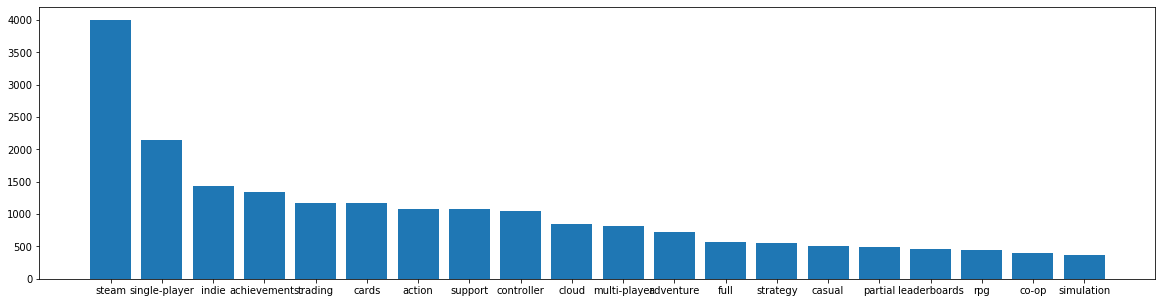

In [351]:
plt.figure(figsize = (20, 5))
plt.bar([word[0] for word in most_common], [word[1] for word in most_common])

In [352]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words=stopwords_list)

In [353]:
tags_list_2 = [' '.join(x) for x in tags_list]

In [354]:
tfidf_matrix = tfidf.fit_transform(tags_list_2)

In [355]:
tfidf_matrix.shape

(568, 554)

In [356]:
#instantiate SVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)

#fit and transform the vectorized tf-idf matrix 
tf_idf_data_train_svd = svd.fit_transform(tfidf_matrix)

In [357]:
print(svd.explained_variance_ratio_.sum())

0.9999999999999993


### Calculating cosine similarities

In [358]:
from sklearn.metrics.pairwise import linear_kernel

In [359]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

### Making recommendations

In [360]:
# creating a Series for the game titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(steam.name)

In [361]:
#  defining the function that takes in game title 
# as input and returns the top 10 recommended games
def recommendations(title, cosine_similarities = cosine_similarities):
    
    # initializing the empty list of recommended movies
    recommended_games = []
    
    # gettin the index of the game that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar games
    top_10_indexes = list(score_series[1:11].index)
    
    # populating the list with the titles of the best 10 matching games
    for i in top_10_indexes:
        recommended_games.append(list(df.name)[i])

    return recommended_games

In [362]:
recommendations('Dota 2')

IndexError: index 9681 is out of bounds for axis 0 with size 568

### Evaluation

<b> MAE & RMSE

In [ ]:
# for Surprise, we only need three columns from the dataset
data = steam[['id', 'name', 'hours_of_play']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

# train-test-split
trainset, testset = train_test_split(data, test_size=.2)

In [ ]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

In [ ]:
# taking a look at the first 10 rows of our test set
predictions[:10]

In [ ]:
print("Number of users: ", df.userId.nunique()) 
print("Number of movies: ", df.movieId.nunique())


In [ ]:
user = 5
item = 100
svd.predict(user, item)

In [ ]:
steam_id_tag = steam['appid']
indices = pd.Series(steam.index, index=sample['appid'])

In [ ]:
def get_most_similar_games(appid, n = 20):
    idx = indices[appid]
    idx = np.array(idx, dtype=np.integer)
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:n]

    game_indices = [i[0] for i in sim_scores]

    recs = pd.DataFrame(columns= steam.columns)
    for i in a_id.loc[game_indices]:

        if i != name: 
            recs = recs.append(steam[steam['appid'] == i])
    return recs

In [ ]:
steam[steam['appid'] == 20]

In [ ]:
get_most_similar_games(20)